<a href="https://colab.research.google.com/github/RyosukeHanaoka/jcr2025/blob/main/best_swin_with_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using device: cuda
Fold 1


<ipython-input-3-d83bd143c8bc>:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/2:   0%|          | 0/13 [00:00<?, ?it/s]

<ipython-input-3-d83bd143c8bc>:145: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-3-d83bd143c8bc>:162: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-3-d83bd143c8bc>:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/2: Train Loss=0.7174, Train Acc=0.5121, Val Loss=0.6804, Val Acc=0.6575


Epoch 2/2:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/2: Train Loss=0.7025, Train Acc=0.5225, Val Loss=0.6676, Val Acc=0.7123
Fold 1 Best Val Acc: 0.7123
Fold 2


Epoch 1/2:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2: Train Loss=0.7286, Train Acc=0.4913, Val Loss=0.6984, Val Acc=0.4384


Epoch 2/2:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/2: Train Loss=0.6919, Train Acc=0.5606, Val Loss=0.6937, Val Acc=0.5205
Fold 2 Best Val Acc: 0.5205
Fold 3


Epoch 1/2:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/2: Train Loss=0.7153, Train Acc=0.5552, Val Loss=0.6913, Val Acc=0.5000


Epoch 2/2:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/2: Train Loss=0.6919, Train Acc=0.6000, Val Loss=0.6809, Val Acc=0.5972
Fold 3 Best Val Acc: 0.5972
Fold 4


Epoch 1/2:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/2: Train Loss=0.7315, Train Acc=0.5069, Val Loss=0.6864, Val Acc=0.5556


Epoch 2/2:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/2: Train Loss=0.7002, Train Acc=0.5034, Val Loss=0.6770, Val Acc=0.5972
Fold 4 Best Val Acc: 0.5972
Fold 5


Epoch 1/2:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/2: Train Loss=0.7155, Train Acc=0.4966, Val Loss=0.6967, Val Acc=0.5139


Epoch 2/2:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/2: Train Loss=0.6815, Train Acc=0.5310, Val Loss=0.6873, Val Acc=0.5278
Fold 5 Best Val Acc: 0.5278

Cross-validation results:
Fold 1 best validation accuracy: 0.7123
Fold 2 best validation accuracy: 0.5205
Fold 3 best validation accuracy: 0.5972
Fold 4 best validation accuracy: 0.5972
Fold 5 best validation accuracy: 0.5278
Average best validation accuracy: 0.5910


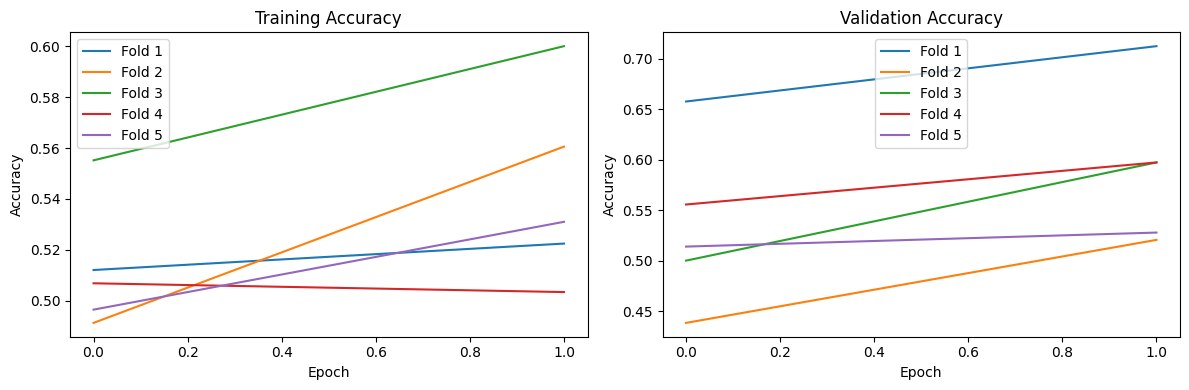

In [3]:
import glob
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from PIL import Image, UnidentifiedImageError
import timm
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import AdamW
from tqdm.notebook import tqdm

# Configurations
class Config:
    batch_size = 96
    epochs = 2
    lr = 0.05 * 3e-4
    gamma = 0.8
    seed = 42
    image_size = 224
    num_workers = 4
    accumulation_steps = 4
    mixup_alpha=0.4
    data_dir_RA = '/content/drive/MyDrive/image_RA'
    data_dir_nonRA = '/content/drive/MyDrive/image_nonRA'

config = Config()

# Seed for reproducibility
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(config.seed)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        try:
            img_path = self.paths[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label

        except UnidentifiedImageError:
            img = Image.new('RGB', (config.image_size, config.image_size), color='gray')
            if self.transform:
                img = self.transform(img)
            return img, 0

# Mixup for regularization
class Mixup:
    def __init__(self, alpha=config.mixup_alpha):
        self.alpha = alpha

    def __call__(self, batch, target):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = len(batch)
        index = torch.randperm(batch_size).to(batch.device)

        mixed_batch = lam * batch + (1 - lam) * batch[index, :]
        target_a, target_b = target, target[index]
        return mixed_batch, target_a, target_b, lam

# Training and validation
def train_with_gradient_accumulation_kfold(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = config.accumulation_steps

    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []
    best_val_acc = 0
    best_model_state = None

    scaler = torch.cuda.amp.GradScaler()
    mixup = Mixup(alpha=config.mixup_alpha)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        samples_seen = 0
        optimizer.zero_grad(set_to_none=True)

        for i, (data, label) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
            data = data.to(device, non_blocking=True)
            label = label.to(device, non_blocking=True)
            batch_size = data.size(0)

            # Training phase consists of two steps:
            # 1. Forward pass with mixup for loss calculation and gradient update
            # 2. Additional forward pass without mixup for accurate training accuracy calculation

            # Step 1: Mixup forward pass for training
            mixed_data, labels_a, labels_b, lam = mixup(data, label)

            with torch.cuda.amp.autocast():
                mixed_output = model(mixed_data)
                # Calculate the original loss without division
                loss = criterion(mixed_output, labels_a) * lam + criterion(mixed_output, labels_b) * (1 - lam)
                # Scale the loss for gradient accumulation only for backward
                scaled_loss = loss / accumulation_steps

            # Backward pass with scaled loss
            scaler.scale(scaled_loss).backward()

            # Update weights if we've accumulated enough gradients
            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            # Step 2: Clean forward pass for accuracy calculation
            with torch.no_grad(), torch.cuda.amp.autocast():
                clean_output = model(data)
                predictions = clean_output.argmax(dim=1)
                running_correct += (predictions == label).sum().item()

            running_loss += loss.item() * batch_size
            samples_seen += batch_size

        # Calculate epoch metrics
        epoch_loss = running_loss / samples_seen
        epoch_accuracy = running_correct / samples_seen

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_samples = 0

        with torch.no_grad():
            for data, label in tqdm(val_loader, desc="Validation"):
                data = data.to(device)
                label = label.to(device)
                batch_size = data.size(0)

                with torch.cuda.amp.autocast():
                    output = model(data)
                    val_batch_loss = criterion(output, label)
                    predictions = output.argmax(dim=1)

                val_loss += val_batch_loss.item() * batch_size
                val_correct += (predictions == label).sum().item()
                val_samples += batch_size

        val_loss /= val_samples
        val_accuracy = val_correct / val_samples

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = model.state_dict().copy()

        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(val_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss={epoch_loss:.4f}, Train Acc={epoch_accuracy:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_accuracy:.4f}")

        scheduler.step()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_acc_list, val_acc_list, train_loss_list, val_loss_list, best_val_acc

def main():
      # Initialize lists to store results before the loop starts
    all_train_acc = []
    all_val_acc = []
    all_train_loss = []
    all_val_loss = []
    fold_best_acc = []
    ra_image_paths = glob.glob(os.path.join(config.data_dir_RA, '*'))
    nonra_image_paths = glob.glob(os.path.join(config.data_dir_nonRA, '*'))
    labels = [1] * len(ra_image_paths) + [0] * len(nonra_image_paths)
    all_paths = ra_image_paths + nonra_image_paths

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config.seed)

    for fold, (train_idx, val_idx) in enumerate(kf.split(all_paths, labels)):
        print(f"Fold {fold+1}")

        train_dataset = CustomDataset(
            [all_paths[i] for i in train_idx],
            [labels[i] for i in train_idx],
            transform=train_transforms
        )
        val_dataset = CustomDataset(
            [all_paths[i] for i in val_idx],
            [labels[i] for i in val_idx],
            transform=val_transforms
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=config.batch_size // config.accumulation_steps,
            shuffle=True,
            num_workers=config.num_workers,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size // config.accumulation_steps,
            shuffle=False,
            num_workers=config.num_workers,
            pin_memory=True
        )

        model = timm.create_model(
            'swin_base_patch4_window7_224.ms_in1k',
            pretrained=True,
            num_classes=2,
            drop_rate=0.4,
            attn_drop_rate=0.3,
            drop_path_rate=0.3
        ).to(device)

        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = AdamW(model.parameters(), lr=config.lr, weight_decay=1e-2)
        scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

        train_acc_list, val_acc_list, train_loss_list, val_loss_list, best_val_acc = train_with_gradient_accumulation_kfold(
            model, train_loader, val_loader, criterion, optimizer, scheduler, device, config.epochs
        )

        print(f"Fold {fold+1} Best Val Acc: {best_val_acc:.4f}")

        # 結果を保存
        all_train_acc.append(train_acc_list)
        all_val_acc.append(val_acc_list)
        all_train_loss.append(train_loss_list)
        all_val_loss.append(val_loss_list)
        fold_best_acc.append(best_val_acc)

        # メモリ解放
        del model, optimizer, scheduler, train_loader, val_loader
        torch.cuda.empty_cache()

    # 最終結果の表示
    print("\nCross-validation results:")
    for fold, acc in enumerate(fold_best_acc):
        print(f"Fold {fold + 1} best validation accuracy: {acc:.4f}")
    print(f"Average best validation accuracy: {sum(fold_best_acc) / len(fold_best_acc):.4f}")

    # 学習曲線のプロット
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for fold in range(len(all_train_acc)):
        # plt.plot([x.cpu() for x in all_train_acc[fold]], label=f'Fold {fold + 1}')
        plt.plot(all_train_acc[fold], label=f'Fold {fold + 1}')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    for fold in range(len(all_val_acc)):
        plt.plot(all_val_acc[fold], label=f'Fold {fold + 1}')
        # plt.plot([x.cpu() for x in all_val_acc[fold]], label=f'Fold {fold + 1}')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    main()
